# Fish ID Model with more data

In lesson 1 we created a fish identification model with 11 classses and 30 hand selected pictures of each fish. This time we're going to see if we can do better by giving the model more data to train on. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.vision import *

We'll collect the data by using some javascript code provided in the course. To use the code, visit google and search for images of the classes the model should learn (in our case different types of fish). Scroll through the images to load them, then open the development console and paste in the code below.
```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```
Once that is done you'll have a csv with a link to each picture. We'll then use the code below to download our images and remove any that we can't open.

In [2]:
rootDir = Path('./auto_data')
classes = [
    'black crappie',
    'bluegill',
    'green sunfish',
    'largemouth bass',
    'pumpkinseed',
    'redear sunfish',
    'rock bass',
    'smallmouth bass',
    'walleye',
    'white crappie',
    'yellow perch'
]

In [ ]:
def downloadData(classes):
    for img_class in classes:
        path = rootDir / img_class
        file = path / (img_class + '.csv')
        download_images(file, path, max_pics=1000, max_workers=0)
        verify_images(path, delete=True, max_size=500)
        
downloadData(classes)

Now that we have downloaded our pictures take a quick look through the folders to make sure the pictures look correct. Then proceed to create our databunch below.

In [3]:
fishData = ImageDataBunch.from_folder(path=rootDir, seed=42, valid_pct=0.1, ds_tfms=get_transforms(), size=299, bs=32).normalize()

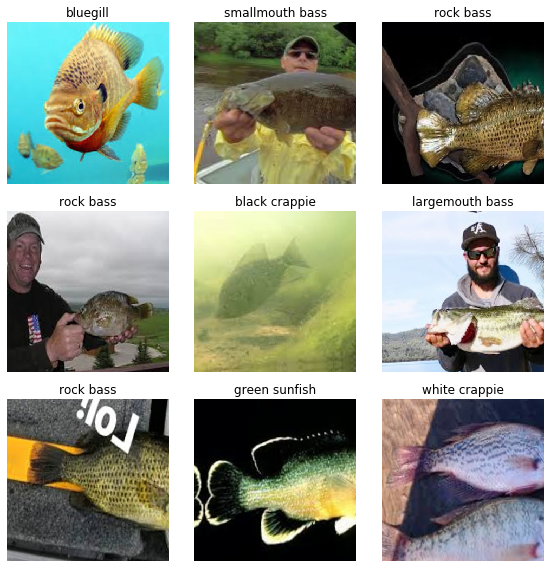

In [4]:
fishData.show_batch(3, figsize=(8,8))

Well, we definitely have some noise in our data. Lets see how our model does...

In [5]:
fishLearner = cnn_learner(fishData, models.resnet50, metrics=[error_rate]).to_fp16()

In [6]:
fishLearner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.456323,1.697887,0.517045,00:23
1,1.894713,1.448492,0.454545,00:20
2,1.511418,1.280177,0.414773,00:21
3,1.251540,1.115384,0.377841,00:19
4,1.043059,1.116222,0.375000,00:20
5,0.909190,1.065644,0.383523,00:20
6,0.794175,1.022960,0.338068,00:20
7,0.713891,1.026523,0.352273,00:20


Not bad, but we know we have a lot of clutter in our data, lets see if that clutter is causing the model some trouble.

In [12]:
fishLearner.save('fish-id-res50-step1')

Create a new dataset and model that we can use to find our top losses and evaluate them.

In [18]:
from fastai.widgets import *
db = (ImageList.from_csv(rootDir, 'cleaned.csv', folder='.')
      .split_none()
      .label_from_folder()
      .transform(get_transforms(), size=299)
      .databunch()
     )

learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)
learn_cln.load('fish-id-res50-step1')
ds, idx = DatasetFormatter().from_toplosses(learn_cln)
ImageCleaner(ds, idx, rootDir)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [17]:
db = (ImageList.from_csv(rootDir, 'cleaned.csv', folder='.')
      .split_none()
      .label_from_folder()
      .transform(get_transforms(), size=299)
      .databunch()
     )

learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)
learn_cln.load('fish-id-res50-step1')
ds, idxs = DatasetFormatter().from_similars(learn_cln)
ImageCleaner(ds, idxs, rootDir, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Now we've cleaned at least some of the noise from our data, lets reload the data and train again.

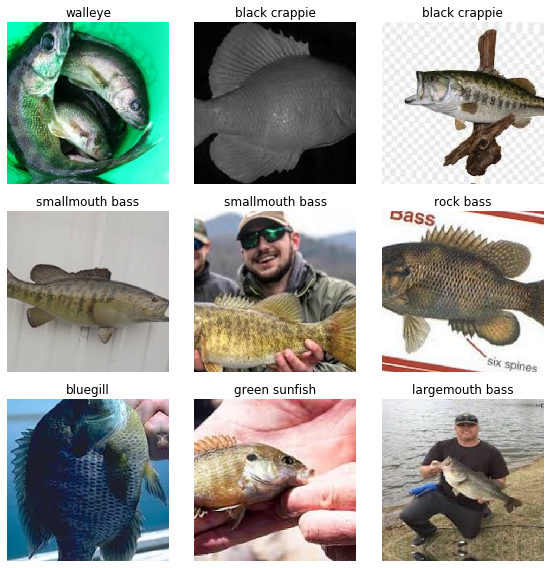

In [23]:
cleanFishData = ImageDataBunch.from_csv(path=rootDir, csv_labels='cleaned.csv', seed=42, valid_pct=0.1, ds_tfms=get_transforms(), size=299, bs=32).normalize()
fishData.show_batch(3, figsize=(8,8))

In [24]:
fishLearner = cnn_learner(fishData, models.resnet50, metrics=[error_rate]).to_fp16()

In [25]:
fishLearner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.450013,1.721515,0.522727,00:20
1,1.895057,1.433238,0.431818,00:20
2,1.520176,1.346053,0.420455,00:20
3,1.250645,1.126497,0.400568,00:20
4,1.071902,1.119792,0.383523,00:20
5,0.904267,1.051172,0.343750,00:20
6,0.775545,1.029959,0.326705,00:21
7,0.699812,1.021944,0.329545,00:21


In [26]:
fishLearner.save('fish-id-res50-step2')

In [28]:
fishLearner.unfreeze()

In [29]:
fishLearner.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.321463,6.671310,0.738636,00:28
1,1.276711,1.007097,0.355114,00:27
2,0.845345,0.896042,0.301136,00:27


In [30]:
fishLearner.save('fish-id_res50-step3')

In [34]:
fishLearner.load('fish-id_res50-step3');

In [35]:
fishLearner.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.046868,2.134847,0.465909,00:27
1,1.200846,1.082808,0.366477,00:27
2,0.793802,0.968196,0.312500,00:27


In [36]:
fishLearner.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.950393,1.597847,0.454545,00:27
1,0.975374,0.993821,0.335227,00:27
2,0.648780,0.906026,0.289773,00:27


In [38]:
fishLearner.fit_one_cycle(8, max_lr=3e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.514586,0.895495,0.281250,00:27
1,0.470645,0.876621,0.284091,00:27
2,0.438203,0.883095,0.292614,00:27
3,0.392939,0.928842,0.284091,00:28
4,0.350689,0.952356,0.289773,00:27
5,0.310075,0.919148,0.289773,00:27
6,0.279179,0.928020,0.275568,00:27
7,0.247705,0.948736,0.295455,00:27


In [39]:
fishLearner.save('fish-id-res50-step4')

In [40]:
fishLearner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     True      
___________________________________________________

In [44]:
results = ClassificationInterpretation.from_learner(fishLearner)

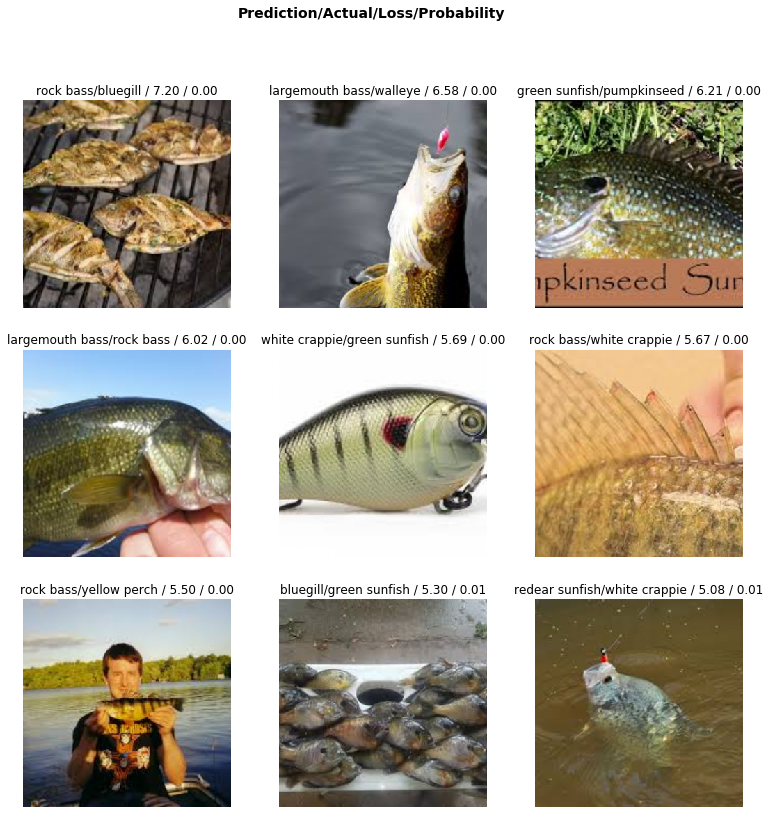

In [47]:
results.plot_top_losses(9,figsize=(13,13))

In [48]:
results.most_confused()

[('black crappie', 'white crappie', 9),
 ('white crappie', 'black crappie', 8),
 ('green sunfish', 'bluegill', 5),
 ('redear sunfish', 'bluegill', 5),
 ('rock bass', 'redear sunfish', 5),
 ('green sunfish', 'pumpkinseed', 4),
 ('pumpkinseed', 'green sunfish', 4),
 ('redear sunfish', 'green sunfish', 4),
 ('bluegill', 'green sunfish', 3),
 ('green sunfish', 'redear sunfish', 3),
 ('largemouth bass', 'smallmouth bass', 3),
 ('redear sunfish', 'pumpkinseed', 3),
 ('walleye', 'largemouth bass', 3),
 ('white crappie', 'redear sunfish', 3),
 ('black crappie', 'largemouth bass', 2),
 ('bluegill', 'redear sunfish', 2),
 ('green sunfish', 'largemouth bass', 2),
 ('largemouth bass', 'walleye', 2),
 ('pumpkinseed', 'redear sunfish', 2),
 ('rock bass', 'largemouth bass', 2),
 ('rock bass', 'smallmouth bass', 2),
 ('walleye', 'smallmouth bass', 2),
 ('walleye', 'yellow perch', 2),
 ('white crappie', 'bluegill', 2),
 ('white crappie', 'rock bass', 2),
 ('yellow perch', 'redear sunfish', 2),
 ('black

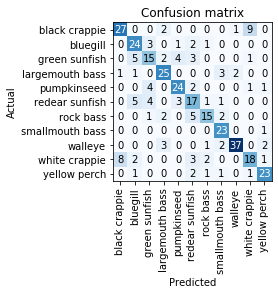

In [49]:
results.plot_confusion_matrix()